## Load and Standardize Datasets

In [108]:
%matplotlib inline
import matplotlib.pyplot as plt
fig_size = (12, 7)
plt.rcParams["figure.figsize"] = fig_size

import pandas as pd

df1 = pd.read_csv('/home/wroscoe/15deg_wide_training_results.csv')
df1['dataset'] = '15deg'

df2 = pd.read_csv('/home/wroscoe/wr_feb_race_30deg_wide_training_results.csv')
df2['dataset'] = '30deg'

df3 = df2.append(df1)
df3['random_seed'] = -1

df4 = pd.read_csv('/home/wroscoe/wr_feb_race_30deg_wide_loop_training_results.csv')
df5 = pd.read_csv('/home/wroscoe/loop2_training_results.csv')
df4 = df4.append(df5)
df4['dataset'] = '30deg'

df6 = df3.append(df4)

In [109]:
col_order = ['dataset','random_seed', 
             'conv_layers', 'dense_layers', 'dropout',
             'learning rate', 'decay', 
             'batch_size', 'epochs', 
             'training_samples', 'validation_samples', 'test_samples',
             'training_loss', 'validation_loss', 'test_loss',
             'model_params', 'training_duration',  
             'training_loss_progress']
df6 = df6[col_order]
df6 = df6.rename(columns={'learning rate': 'learning_rate'})
df6 = df6.reset_index(drop=True)

df6.to_csv('~/mydonkey/donkey_model_search_data.csv', index=False)

df6.columns

Index(['dataset', 'random_seed', 'conv_layers', 'dense_layers', 'dropout',
       'learning_rate', 'decay', 'batch_size', 'epochs', 'training_samples',
       'validation_samples', 'test_samples', 'training_loss',
       'validation_loss', 'test_loss', 'model_params', 'training_duration',
       'training_loss_progress'],
      dtype='object')

# Finding a better driving model. 
Recently I've been working with a group of friends to build a [self driving RC cars platform](https://github.com/wroscoe/donkey) as part of a local [DIY Robocars](http://diyrobocars.com/) group that races the cars every month.

The Donkey car platform we've (mostly [Adam Conway](https://twitter.com/acb0t)) come up with is simple. It can be built in 4 hours and costs $140 (including the cost of the car). You should totally build one. 


Given that the hardware now works reliably, we are focused on improving the autopilots to follow a the track and eventually make tacticle manouvers to beat out other cars. Our current autopilot is an Keras/Tensorflow model that we train with driving data we collect by mannually driving the car arround the track. I wrote a post about this method here.

#### Our Problem
These neural networks are fickle beasts. Our poblem to date has been that our driving models only sometimes wor and it hasn't been clear how to fix it. Dow we need more training data, different model parameters, or a completely different network archetecture. This notebook walks through how I found a better driving model. 

#### The Approach
I don't have a great intution about neural network archetectures so I decided to try thousands of different models and then see if I could find any insights from the results. The steps I followed are..
1. Write a script to train, test and record the results for many different models.
2. Isolate the variables to understand their affect on performance.
2. Prioritize small models. 



## Get the test results

In [110]:
df = pd.read_csv('~/mydonkey/donkey_model_search_data.csv')
df.shape

(4564, 18)

In [111]:
print(df.shape)
print(list(df.columns))

(4564, 18)
['dataset', 'random_seed', 'conv_layers', 'dense_layers', 'dropout', 'learning_rate', 'decay', 'batch_size', 'epochs', 'training_samples', 'validation_samples', 'test_samples', 'training_loss', 'validation_loss', 'test_loss', 'model_params', 'training_duration', 'training_loss_progress']


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f4b65b48208>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f4b660ec320>]], dtype=object)

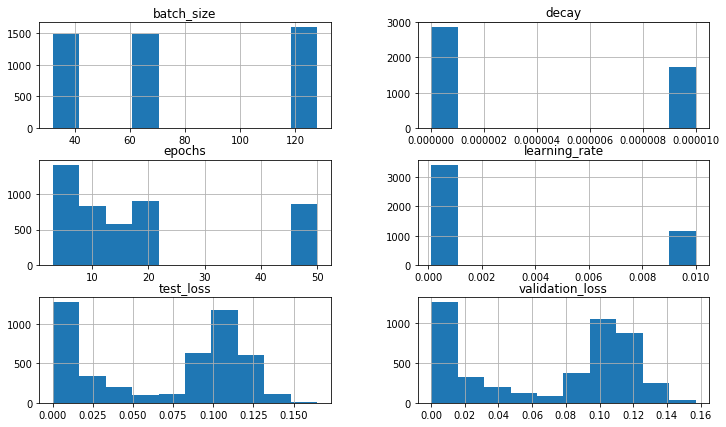

In [112]:
df.hist(column=['test_loss', 'validation_loss', 'epochs', 'batch_size', 'learning_rate', 'decay'])

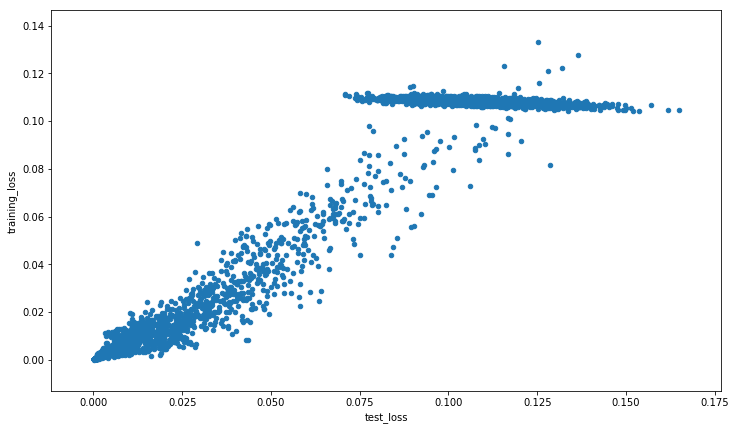

In [113]:
df = df.sort_values('test_loss').reset_index(drop=True)
df.plot.scatter(x='test_loss', y='training_loss')

In [114]:

def plot_catscat(d, cat, val):
    df = d[[cat, val]].sort_values([cat, val]).reset_index(drop=True)
    groups = df.groupby([cat])

    # Plot
    fig, ax = plt.subplots()
    ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling
    ax.set_title('{} vs {}'.format(cat, val))

    for name, group in groups:
        ax.plot(group[val], group.index, marker='o', linestyle='', ms=12, label=name)
    ax.legend()
    ax.set_xlabel(val)

    plt.show()

## How can we keep model size down?
We'd like to keep model size small so that we can perform the steering predictions fast. Lets get an intuition about how big these models are by seeing how many parameters are in these models with different dense layers and convolution layers.

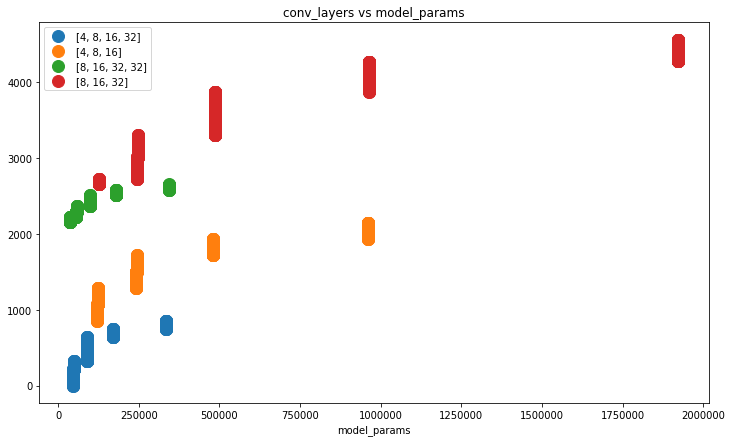

In [115]:
plot_catscat(df, 'conv_layers', 'model_params')

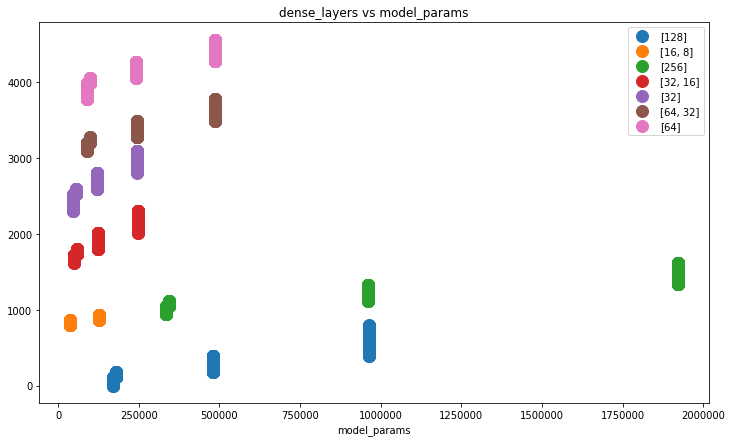

In [116]:
plot_catscat(df, 'dense_layers', 'model_params')

Models are bigger with more dense neurons but generally smaller with more convolution layers. The majority of parameters are inte the dense layers.

### How do we find the best model parameters? 
Lets start working through the parameters that most affect the model size and and filter only the patameters and network archetectures that work best. Here are t
* The model must always converge.
* The error must be lower than .02 (a heuristic of model that will follow a track)
* Prioritize smaller models.

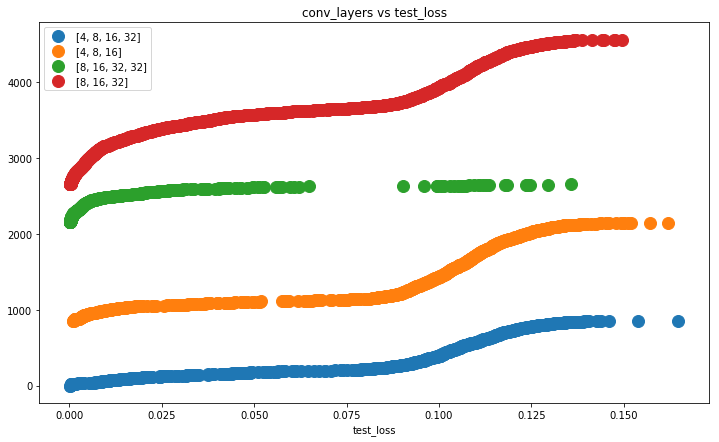

In [122]:
plot_catscat(df, 'conv_layers', 'test_loss')

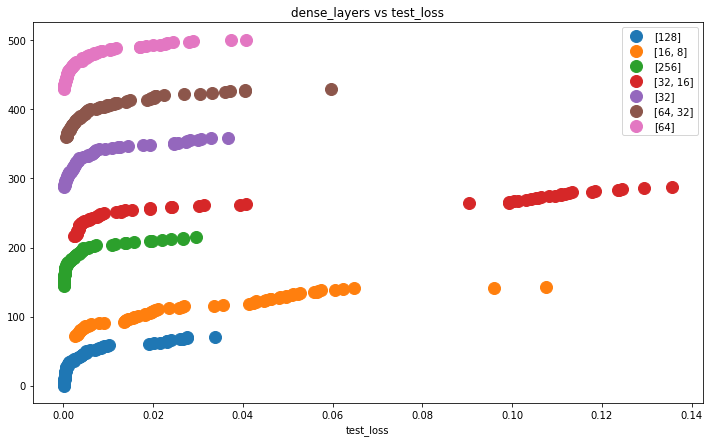

In [118]:
df_c = df6[df6['conv_layers']=='[8, 16, 32, 32]']
plot_catscat(df_c, 'dense_layers', 'test_loss')

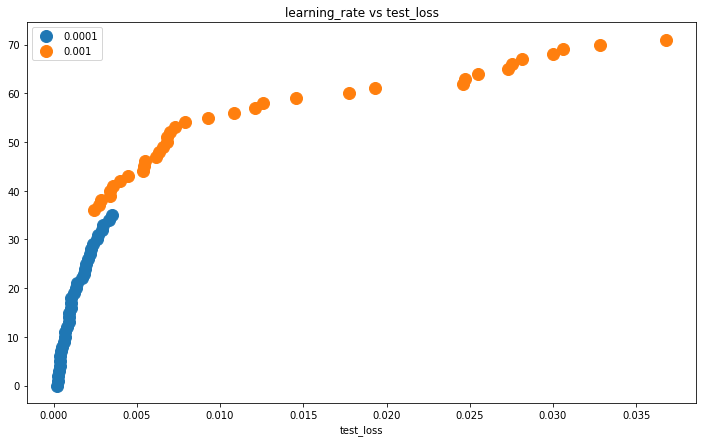

In [119]:
df_cd = df_c[df_c['dense_layers']=='[32]']
plot_catscat(df_cd, 'learning_rate', 'test_loss')

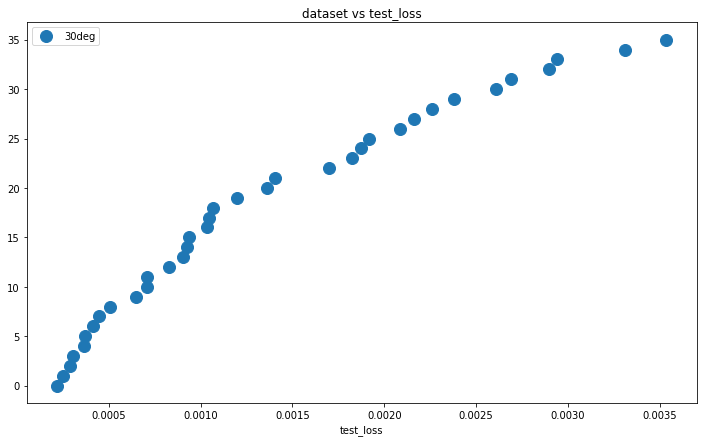

In [125]:
df_cdl = df_cd[(df_cd['learning_rate']==.0001)]
plot_catscat(df_cdl, 'dataset', 'test_loss')

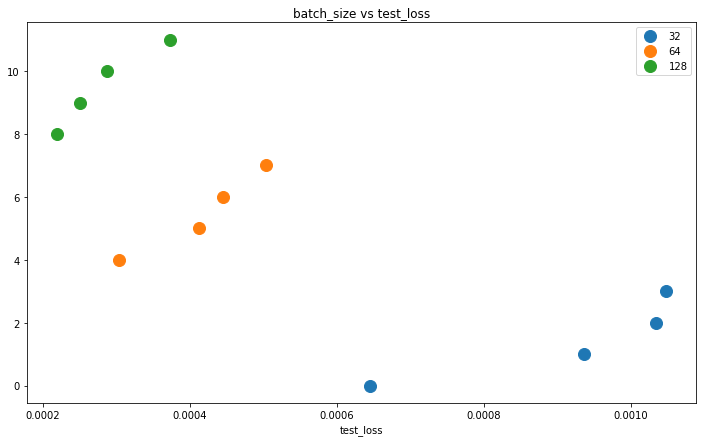

In [126]:

df_cdld = df_cdl[(df_cdl['dropout']==.2)]
plot_catscat(df_cdld, 'batch_size', 'test_loss')

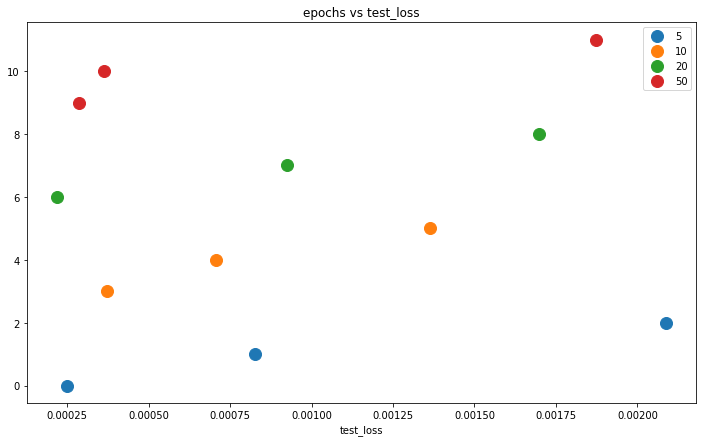

In [127]:

df_cdld = df_cdl[(df_cdl['batch_size']==128)]
plot_catscat(df_cdld, 'epochs', 'test_loss')

In [ ]:

df6.sort_values('test_loss').reset_index(drop=True)[['test_loss', 'validation_loss']].plot()

In [ ]:
df6.sort_values('test_loss').reset_index(drop=True).plot.scatter(x='test_loss', y='epochs')

In [ ]:
from pandas.tools.plotting import scatter_matrix

In [ ]:
scatter_matrix(df6[['test_loss', 'decay', 'learning_rate' ]])

### Do model intial weights matter when training?

In [ ]:
dfs = df6[df6['random_seed']==5124]
f = {'test_loss':['count', 'mean', 'min', 'max']}
dfs.groupby(['conv_layers', 'dense_layers', 'epochs', 'batch_size', 'random_seed']).agg(f)



### Do the validation, test set section matter?





df6['dense_layers'].value_counts().sort_index()